This is a boltzmann machine inspired by the article: Quantum Boltzmann Machine, mohammad H amin

In [2]:
#import the necessary shit
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

import dimod
from dimod.reference.samplers import SimulatedAnnealingSampler
import dwave_networkx as dnx
from minorminer import find_embedding
# from dwave.system.samplers import DWaveSampler
from dwave.system.composites import FixedEmbeddingComposite
%matplotlib inline

#Training rate
𝜁=0.05

In [3]:
class SRQBM():
    def __init__(self,num_visible,num_hidden):
        self.num_visible=num_visible
        self.num_hidden=num_hidden
        self.Q={}
        self.network={'lateral_hidden_weights': 0*np.random.rand(num_hidden, num_hidden-1),'lateral_visible_weights': 0*np.random.rand(num_visible, num_visible-1),'visible_to_hidden_weights': np.random.rand(num_visible, num_hidden)-0.5,'vbias': np.random.rand(num_visible)-0.5,'hbias': np.random.rand(num_hidden)-0.5}
    def set_up_QUBO(self,v=None,h=None):
        if v is None:
            v=self.network['vbias']
        if h is None:
            h=self.network['hbias']            
        for i in range(0,self.num_visible):
            self.Q[(i,i)]=v[i]
            for j in range(0,self.num_visible):
                if i >j:
                    self.Q[(i,j)]=self.network['lateral_visible_weights'][i][j]
                elif j> i:
                    self.Q[(i,j)]=self.network['lateral_visible_weights'][i][j-1]
            for j in range(self.num_visible,self.num_visible+self.num_hidden):
                self.Q[(i,j)]=self.network['visible_to_hidden_weights'][i][j-self.num_visible]
        for j in range(self.num_visible,self.num_visible+self.num_hidden):
            self.Q[(j,j)]=h[j-self.num_visible]
    def do_embedding(self, A):
        i=0
        self.embedding=None
        while self.embedding is None and i<10:
            self.embedding = find_embedding(self.Q, A)
            i+=1
        self.max_chain_length=max(len(chain) for chain in self.embedding.values())
        
    def sample_h_fixed(self, x, num_runs=10):
        chainstrength=2
        self.set_up_QUBO(h=(-4*x+2))
        #hk=FixedEmbeddingComposite(DWaveSampler(solver={'lower_noise': True, 'qpu': True}), self.embedding).sample_qubo(self.Q, chain_strength=chainstrength, auto_scale=False, num_reads=1)
        #h=FixedEmbeddingComposite(DWaveSampler(solver={'lower_noise': True, 'qpu': True}), self.embedding).sample_qubo(self.Q, chain_strength=chainstrength, auto_scale=False, num_reads=10000)      
        #self.response = FixedEmbeddingComposite(DWaveSampler(solver={'lower_noise': True, 'qpu': True}), self.embedding).sample_qubo(self.Q, chain_strength=chainstrength, auto_scale=False, num_reads=10000)
        h=SimulatedAnnealingSampler().sample_qubo(self.Q, num_reads=num_runs)
        ph=deepcopy(h.record[0][0][:])*h.record[0][2]
        sample_length=len(h)
        for i in range(1,sample_length):    
            ph+= h.record[i][0][:]*h.record[0][2]
        ph=ph/10000 
        return ph, h
    
    def sample_v_fixed(self, x, num_runs=10):
        chainstrength=2
        self.set_up_QUBO(v=(-4*x+2))
        #vk=FixedEmbeddingComposite(DWaveSampler(solver={'lower_noise': True, 'qpu': True}), self.embedding).sample_qubo(self.Q, chain_strength=chainstrength, auto_scale=False, num_reads=1)
        #v=FixedEmbeddingComposite(DWaveSampler(solver={'lower_noise': True, 'qpu': True}), self.embedding).sample_qubo(self.Q, chain_strength=chainstrength, auto_scale=False, num_reads=10000)
        #self.response = FixedEmbeddingComposite(DWaveSampler(solver={'lower_noise': True, 'qpu': True}), self.embedding).sample_qubo(self.Q, chain_strength=chainstrength, auto_scale=False, num_reads=10000) 
        v=SimulatedAnnealingSampler().sample_qubo(self.Q, num_reads=num_runs)
        #pv=deepcopy(self.response.record[0][0][0 : (self.num_visible)])
        pv=deepcopy(v.record[0][0][:])*v.record[0][2] #<Za>v
        ZaZb_v=np.array([v.record[0][0][:]]) *  np.array([v.record[0][0][:]]).T*v.record[0][2] #<ZaZb>v
        sample_length=len(v)
        for i in range(1,sample_length):
            pv+= v.record[i][0][:]*v.record[i][2]  #(self.num_visible) 
            ZaZb_v+=np.array([v.record[i][0][:]]) *  np.array([v.record[i][0][:]]).T*v.record[i][2]
        pv=pv/sample_length
        ZaZb_v=ZaZb_v/sample_length
        ZaZb_v=ZaZb_v[~np.eye(ZaZb_v.shape[0],dtype=bool)].reshape(ZaZb_v.shape[0],-1)
        return pv, v, ZaZb_v
    
    def sample(self,num_runs=10):
        chainstrength=2
        self.set_up_QUBO()
        #v=FixedEmbeddingComposite(DWaveSampler(solver={'lower_noise': True, 'qpu': True}), self.embedding).sample_qubo(self.Q, chain_strength=chainstrength, auto_scale=False, num_reads=num_runs)
        v=SimulatedAnnealingSampler().sample_qubo(self.Q, num_reads=num_runs)
        ps=deepcopy(v.record[0][0][:]) #<Za>
        ZaZb=np.array([v.record[0][0][:]]) *  np.array([v.record[0][0][:]]).T*v.record[0][2] #<ZaZb>v #<ZaZb>
        sample_length=len(v)
        for i in range(1,sample_length):
            ps+= v.record[i][0][:]*v.record[i][2]  #(self.num_visible) 
            ZaZb+=np.array([v.record[i][0][:]]) *  np.array([v.record[i][0][:]]).T*v.record[i][2]
        ps=ps/sample_length    
        ZaZb=ZaZb/sample_length
        ZaZb=ZaZb[~np.eye(ZaZb.shape[0],dtype=bool)].reshape(ZaZb.shape[0],-1)
        return ps, v, ZaZb
    
    def classical_train(self, Za_v_bar, Za, ZaZb_v_bar, ZaZb):
        self.network['visible_to_hidden_weights'] = self.network['visible_to_hidden_weights'] + 𝜁 *(ZaZb_v_bar[self.num_visible:(self.num_visible+self.num_hidden),:self.num_visible].T-ZaZb[self.num_visible:(self.num_visible+self.num_hidden),:self.num_visible].T)
        #print(Za_v_bar[:self.num_visible]-Za[:self.num_visible])
        self.network['vbias'] = self.network['vbias'] + 𝜁 *(Za_v_bar[:self.num_visible]-Za[:self.num_visible])
        self.network['hbias'] = self.network['hbias'] + 𝜁 *(Za_v_bar[self.num_visible:]-Za[self.num_visible:])
        
    def draw_graph(self):
        connectivity_structure = dnx.chimera_graph(16,16)
        fig=plt.figure(figsize=(25, 25))
        dnx.draw_chimera_embedding(connectivity_structure, self.embedding)

In [4]:
def train_rbm(rbm,nb_epoch, K, train_dataset):
    for epoch in range(0, nb_epoch):
        train_loss = 0
        Za_v_bar=0
        ZaZb_v_bar=0
        s = 0
        train_len=len(train_dataset)
        for i in range(0, train_len):
            v0 = train_dataset[i]
            Za_v,_,ZaZb_v=rbm.sample_v_fixed(v0)
            Za_v_bar += (1/train_len)*Za_v
            ZaZb_v_bar += (1/train_len)*ZaZb_v
            a=Za_v_bar[:rbm.num_visible]
            b=Za_v[:rbm.num_visible]
            s += 1.
        Za,_,ZaZb = rbm.sample()
        rbm.classical_train(Za_v_bar, Za, ZaZb_v_bar, ZaZb)
        train_loss = np.mean((Za_v_bar - Za))
        print('epoch: '+str(epoch)+' loss: '+str(train_loss))
        rbm.set_up_QUBO()
    return train_loss

In [5]:
def data_generator(num_data_points, noise_probability,dim):
    one = np.zeros((dim,dim))
    two = np.zeros((dim,dim))
    one[1, :] = 1 
    one[:, 1] = 1
    two[np.arange(dim),np.arange(dim)]=1
    two[np.arange(dim), -np.arange(dim)-1]=1
    data={}
    for i in range(0,num_data_points):
        if np.random.binomial(1, 0.5)==1:
            data[i]=one.reshape(dim**2)+(np.random.rand(dim**2)<noise_probability).astype(int)
            data[i]=np.mod(data[i],2)
        else:
            data[i]=two.reshape(dim**2)+(np.random.rand(dim**2)<noise_probability).astype(int)
            data[i]=np.mod(data[i],2)
    return data

[(0, {}), (1, {}), (2, {}), (3, {}), (4, {}), (5, {}), (6, {}), (7, {}), (8, {}), (9, {}), (10, {})]
[(0, {'subset': True}), (1, {'subset': True}), (2, {'subset': True}), (3, {'subset': True}), (4, {'subset': True}), (5, {'subset': True}), (6, {'subset': True}), (7, {'subset': True}), (8, {'subset': True}), (9, {'subset': False}), (10, {'subset': False})]


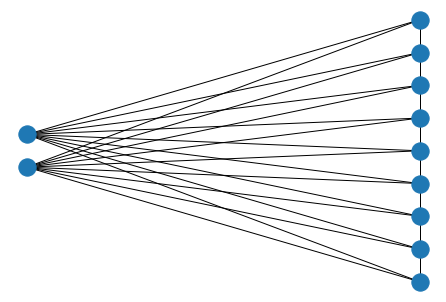

In [6]:
import networkx as nx

dim=3;input_dim = dim * dim;hidden_dim = 2;nb_epoch = 6;K=1
rbm=SRQBM(input_dim,hidden_dim)
rbm.set_up_QUBO()
G = nx.Graph(rbm.Q.keys())
print(G.nodes(data=True))
subsets = {v:v<input_dim for v in G}
nx.set_node_attributes(G,subsets,"subset")
print(G.nodes(data=True))
nx.draw(G,nx.multipartite_layout(G))

dim=3
input_dim = dim * dim
hidden_dim = 2
nb_epoch = 6
K=1

rbm=SRQBM(input_dim,hidden_dim)
rbm.set_up_QUBO()
dwave_sampler = DWaveSampler(solver={'lower_noise': True, 'qpu': True})
A = dwave_sampler.edgelist
rbm.do_embedding(A)
rbm.draw_graph()
rbm.max_chain_length

We can generate some data. It can even be noisy!

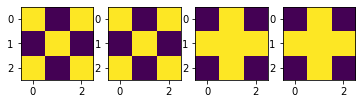

In [7]:
#generate some data
np.random.seed(26)
data=data_generator(4, 0.0, dim)
fig, ax = plt.subplots(ncols=4)
ax[0].imshow(data[0].reshape(dim,dim))
ax[1].imshow(data[1].reshape(dim,dim))
ax[2].imshow(data[2].reshape(dim,dim))
ax[3].imshow(data[3].reshape(dim,dim))

In [8]:
train_rbm(rbm, 5, K, data)

epoch: 0 loss: -0.052272727272727276
epoch: 1 loss: 0.0409090909090909
epoch: 2 loss: -0.015909090909090904
epoch: 3 loss: 0.059090909090909104
epoch: 4 loss: 0.07272727272727272


0.07272727272727272

In [9]:
rbm.network

{'hbias': array([-0.26652159,  0.39186977]),
 'lateral_hidden_weights': array([[0.],
        [0.]]),
 'lateral_visible_weights': array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]]),
 'vbias': array([-0.41737932,  0.27800171,  0.39632156, -0.51360866, -0.26886124,
         0.55035809,  0.35560648, -0.56006554, -0.18318526]),
 'visible_to_hidden_weights': array([[-0.49791789, -0.25752762],
        [-0.01991548,  0.26215806],
        [ 0.0210212 ,  0.36835743],
        [ 0.40536665, -0.08797406],
        [ 0.03055453, -0.36377171],
        [ 0.32929035,  0.11622149],
        [-0.30544221,  0.42062438],
        [-0.10230285, -0.14528505],
        [ 0.34173107, -0.361194

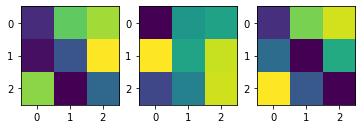

In [10]:
fig, ax=plt.subplots(ncols=3)
ax[0].imshow(rbm.network['vbias'].reshape(dim,dim))
ax[1].imshow(rbm.network['visible_to_hidden_weights'][:,0].reshape(dim,dim))
ax[2].imshow(rbm.network['visible_to_hidden_weights'][:,1].reshape(dim,dim))

In [15]:
_,H=rbm.sample_h_fixed(np.array([1,1]))

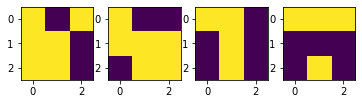

In [17]:
fig, ax = plt.subplots(ncols=4)

for i in range(4):
    ax[i].imshow(H.record[i][0][:9].reshape(dim,dim))

In [16]:
H.record

rec.array([([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1], -5.5222839 , 1),
           ([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1], -5.98555148, 1),
           ([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1], -6.06231239, 1),
           ([1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1], -4.67453378, 1),
           ([1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1], -5.5936428 , 1),
           ([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1], -6.98142141, 1),
           ([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1], -6.77877275, 1),
           ([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1], -6.26496106, 1),
           ([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1], -6.98142141, 1),
           ([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1], -6.77877275, 1)],
          dtype=[('sample', 'i1', (11,)), ('energy', '<f8'), ('num_occurrences', '<i4')])

### Boltzmann machine useful papers:

1. Roux, N. L. & Bengio, Y. Representational power of restricted Boltzmann machines and deep belief networks. Neural Comput. 20, 1631–1649 (2008).
2. Restricted Boltzmann machines in quantum physics
3. Quantum Boltzmann Machine, mohammad H amiin